In [1]:
using Plots, LinearAlgebra, Random, StatsBase, SparseArrays, CSV, DataFrames, Tables

In [2]:
content = rowtable(CSV.read("ncaa-2023.csv", DataFrame, header=false))

5610-element Vector{@NamedTuple{Column1::String, Column2::String15, Column3::String, Column4::Float64, Column5::Float64, Column6::Int64, Column7::Int64, Column8::Int64, Column9::Int64, Column10::Float64, Column11::Float64}}:
 (Column1 = "Mississippi Valley St.Baylor11-7", Column2 = "11/7/22", Column3 = "Baylor -37.0, 95-58 (100%)", Column4 = 58.08219264, Column5 = 95.10164256, Column6 = 53, Column7 = 117, Column8 = 355, Column9 = 2, Column10 = 72.61017799, Column11 = 29.83936953)
 (Column1 = "BresciaMiddle Tennessee11-7", Column2 = "11/7/22", Column3 = "Middle Tennessee (100%)", Column4 = 51.57063963, Column5 = 92.52730733, Column6 = 52, Column7 = 79, Column8 = 0, Column9 = 100, Column10 = 70.6356741, Column11 = 0.55918372)
 (Column1 = "PacificStanford11-7", Column2 = "11/7/22", Column3 = "Stanford -19.1, 82-62 (96%)", Column4 = 62.4924586, Column5 = 81.59700436, Column6 = 78, Column7 = 88, Column8 = 254, Column9 = 37, Column10 = 70.3686906, Column11 = 35.83878057)
 (Column1 = "Valley 

In [3]:
"""Games are stored in this really weird way

gameid = Coppin St.Charlotte11-7
predict = Charlotte -10.9, 83-72 (84%)
So we are going to match predict against

"""
function parse_game(gameid, predict)
    m = match(r"([\w.' ]+) ([ -1234567890,.\(\)%]+)", predict)
    if m === nothing
        println(predict)
    end
    team1 = m.captures[1]
    # remove the digits at the end... 
    m2 = match(r"^([a-zA-Z\(\)&'-. ]+)[\d-]+$", gameid)
    if m2 === nothing
        println(gameid)
    end 
    gameid = m2.captures[1]
    team2 = filter!(x->length(x) > 0, split(gameid, team1))[1]
    # it's possible team2 still has bad symbols... 
    # but maybe 
    return team1, team2
end 
gamedata = map(content) do row
    score1 = row.Column6
    score2 = row.Column7
    gameid = row.Column1
    date = row.Column2
    predict = row.Column3
    team1,team2 = parse_game(gameid, predict)
    return (team=team1, opponent=team2, date, teamscore=score2, opponentscore=score1)
end |> DataFrame

5610×5 DataFrame
  Row │ team               opponent                date      teamscore  oppone ⋯
      │ SubStrin…          SubStrin…               String15  Int64      Int64  ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ Baylor             Mississippi Valley St.  11/7/22         117         ⋯
    2 │ Middle Tennessee   Brescia                 11/7/22          79
    3 │ Stanford           Pacific                 11/7/22          88
    4 │ James Madison      Valley Forge            11/7/22         123
    5 │ UNC Greensboro     JWU (Charlotte)         11/7/22          93         ⋯
    6 │ Harvard            Morehouse               11/7/22          63
    7 │ Oakland            Defiance                11/7/22          92
    8 │ Charlotte          Coppin St.              11/7/22          82
    9 │ Villanova          La Salle                11/7/22          81         ⋯
   10 │ Michigan           Fort Wayne              11/7/22          75
   11 │ UMass Lowell       Fisher                  11/7/22         108
  ⋮   │         ⋮                    ⋮                ⋮          ⋮             ⋱
 5601 │ Tulane             Wichita St.             2/26/23          76
 5602 │ UCLA               Colorado                2/26/23          56         ⋯
 5603 │ Bradley            Drake                   2/26/23          73
 5604 │ UCF                Tulsa                   2/26/23          49
 5605 │ Murray St.         Valparaiso              2/26/23          77
 5606 │ Penn St.           Rutgers                 2/26/23          56         ⋯
 5607 │ Stanford           Washington              2/26/23          81
 5608 │ Stephen F. Austin  Cal Baptist             2/26/23          80
 5609 │ Stanford           Washington              2/26/23          81
 5610 │ Stephen F. Austin  Cal Baptist             2/26/23          80         ⋯
                                                  1 column and 5589 rows omitted

## Least-squares fitting with Stochastic Gradient Descent

We will rank sports teams using a variant of least squares 

In [4]:
## Convert teams into numbers and also build our game table
m = size(content,1)
teams_dict = Dict{String,Int}()
teams = Vector{String}()
index = 1
data = Array{Int64}(undef, m, 4)
for i = 1 : m
    team = gamedata[!,:team][i]
    opponent = gamedata[!,:opponent][i]
    teamscore = gamedata[!,:teamscore][i]
    oppscore = gamedata[!,:opponentscore][i]
    if !haskey(teams_dict, team)
        push!(teams, team)
        teams_dict[team] = index
        index = index + 1
    end

    if !haskey(teams_dict, opponent)
        push!(teams, opponent)
        teams_dict[opponent] = index
        index = index + 1
    end

    data[i, 1] = teams_dict[team]
    data[i, 2] = teams_dict[opponent]
    data[i, 3] = teamscore
    data[i, 4] = oppscore
end

In [5]:
index

791

In [6]:
# stochastic gradient descent works on a collection
# of functions, each of which provides their own gradient
mutable struct SGD
    fs::Vector{Function} # we will randomly sample data
    x::Vector # current point
end
function gradient(M::SGD) # return the Gradient
    g = similar(M.x)
    N = length(M.fs)
    fill!(g, zero(eltype(M.x)))
    for i=1:length(M.fs)
        g .+= (1.0/N)*gradient(M,i) # get the second output, which is the gradient
    end
    return g
end
function Hessian(M::SGD)
    mean(map(i->Hessian(M,i), 1:length(M.fs)))
end 
function gradient(M::SGD, i::Int)
    return M.fs[i](M.x)[2] # the second output is the gradient
end
function Hessian(M::SGD, i::Int)
    return M.fs[i](M.x)[3] # the third output is the Hessian
end 
function fval(M::SGD)
    f = 0.0 
    N = length(M.fs)
    for i=1:length(M.fs)
        f += (1.0/N)*M.fs[i](M.x)[1] # first output is fval 
    end
    return f
end 
## Setup least squares
function sports_loss(x,i,j,s)
    d = (x[i] - x[j] -s)
    f = 0.5*(d)^2
    g = zeros(length(x))
    g[i] = d
    g[j] = -d 
    H = sparse([i,i,j,j],[i,j,i,j],[1.0,-1,-1,1],length(x),length(x))
    return f, g, H
end
## This set up is for the problem
opt = SGD(
    collect(map(game_i -> # game i maps to loss function i 
        (x -> sports_loss(x, data[game_i,1], data[game_i,2], 
                data[game_i,3] - data[game_i,4])),
        1:size(data,1))),
    zeros(length(teams_dict))
)
##
g = gradient(opt)
#m.fs[1](m.x)


790-element Vector{Float64}:
 -0.05525846702317291
  0.06809269162210337
 -0.026024955436720138
  0.026203208556149733
 -0.02584670231729055
  0.010695187165775406
 -0.040641711229946524
  0.015151515151515152
 -0.012299465240641709
  0.01158645276292335
  0.00802139037433155
  0.0033868092691622105
  0.007130124777183602
  ⋮
  0.0042780748663101605
 -0.00196078431372549
  0.0010695187165775401
  0.00089126559714795
  0.00409982174688057
  0.006060606060606061
  0.00196078431372549
  0.008556149732620321
  0.00035650623885918
 -0.00071301247771836
  0.01301247771836007
  0.00017825311942959

In [7]:
## Validate the gradient
m = size(data,1)
B = zeros(m, length(teams))
p = zeros(m)
for i=1:m
    # form the model
    ti = data[i,1]
    tj = data[i,2]
    p[i] = data[i,3] - data[i,4]
    B[i,ti] = 1
    B[i,tj] = -1
end
gtest = 1/size(B,1)*B'*(-p)
norm(g-gtest)

9.711277220295703e-17

In [8]:
## Validate the Hessian
norm(B'*B/size(B,1) - Hessian(opt))

0.0

In [9]:
function gradient_descent_step!(m::SGD)
    g = gradient(m)
end 

gradient_descent_step! (generic function with 1 method)

In [10]:
function sgd_step!(m::SGD, alpha)
    f = rand(m.fs) # generate a random f
    m.x .-= alpha*f(m.x)[2] # the 2nd output is the gradient 
end
function sgd_step!(m::SGD, S::Integer, alpha)
    f = rand(m.fs) # generate a random f
    eg = alpha*f(m.x)[2]/S
    for j in 2:S
        f = rand(m.fs) # generate a random f
        eg .+= alpha*f(m.x)[2]/S
    end 
    m.x .-= eg # the 2nd output is the gradient 
end

norms = zeros(0)
fvals = zeros(0)
for i=1:100 
    for j=1:100 # show gradient every few steps
        sgd_step!(opt, 0.001) # How to set alpha? 
    end
    push!(norms, norm(gradient(opt)))
    push!(fvals, fval(opt))
end

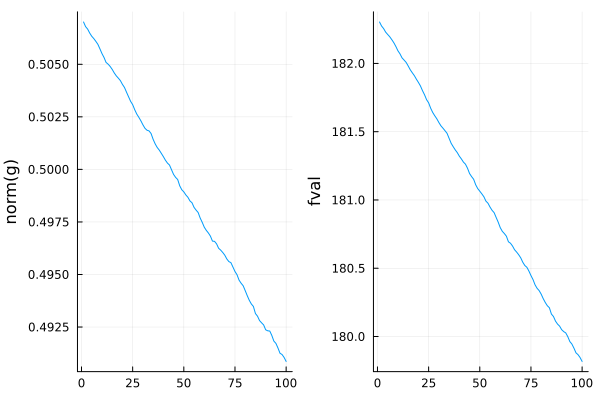

In [11]:
plot(
    plot(norms, label="", ylabel="norm(g)"),
    plot(fvals, label="", ylabel="fval")
    )

In [12]:
norms = zeros(0)
fvals = Float64[] 
opt.x = zeros(length(opt.x))
for i=1:100
    for j=1:100 # show gradient every few steps
        sgd_step!(opt, 0.01) # How to set alpha? 
    end
    push!(norms, norm(gradient(opt)))
    push!(fvals, fval(opt))
end

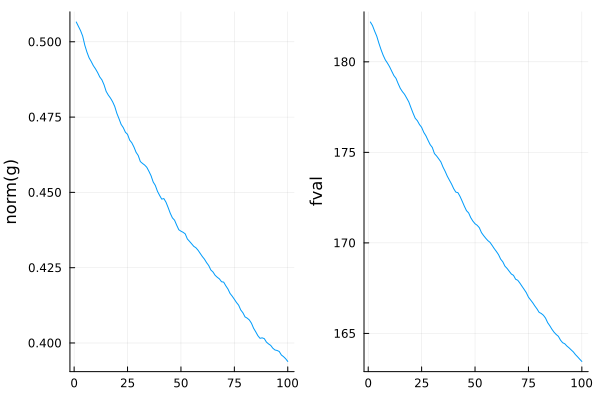

In [13]:
plot(
    plot(norms, label="", ylabel="norm(g)"),
    plot(fvals, label="", ylabel="fval")
)

In [14]:
norms = zeros(0)
fvals = Float64[]
opt.x = zeros(length(opt.x))
for i=1:100
    sgd_step!(opt, 100, 0.1) # How to set alpha? 
    push!(norms, norm(gradient(opt)))
    push!(fvals, fval(opt))
end

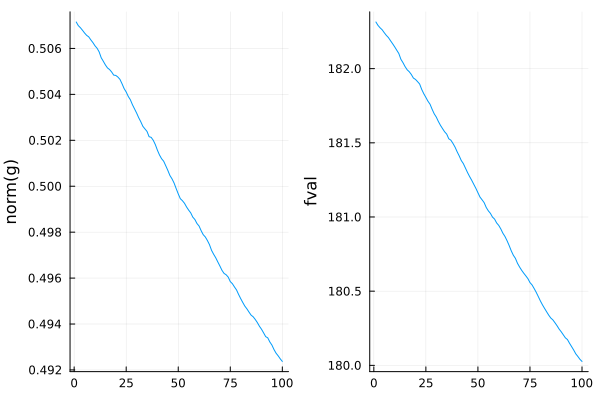

In [15]:
plot(
    plot(norms, label="", ylabel="norm(g)"),
    plot(fvals, label="", ylabel="fval")
)

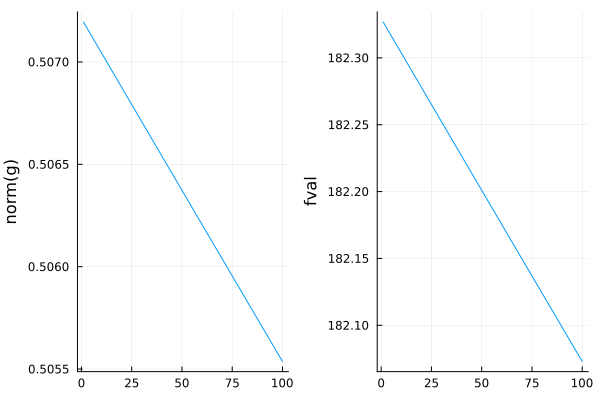

In [16]:
norms = zeros(0)
opt.x = zeros(length(opt.x))
fvals = zeros(0)
for i=1:100
    g = gradient(opt)
    opt.x .-= 0.01*g
    push!(norms, norm(gradient(opt)))
    push!(fvals, fval(opt))
end
plot(
    plot(norms, label="", ylabel="norm(g)"),
    plot(fvals, label="", ylabel="fval")
)

In [ ]:
function sn_step!(m::SGD, S::Integer, T::Integer, )
    sH = mean(i->m.fs[i](m.x)[3], rand(1:length(m.fs), T))
    sg = mean(i->m.fs[i](m.x)[2], rand(1:length(m.fs), S))

    # heuristic scaling to make the model 
    # defined in all coordinates... 
    gamma = T/(2*length(m.fs)*log(length(m.fs)))
    gamma = max(1/4 - gamma,0)
    p = (sH + gamma*I)\(-sg)
    
    m.x .+= p
end 
##
norms = zeros(0)
opt.x = zeros(length(opt.x))
fvals = zeros(0)
for i=1:100
    sn_step!(opt, 100, 100) 
    push!(norms, norm(gradient(opt)))
    push!(fvals, fval(opt))
end
plot(
    plot(norms, label="", ylabel="norm(g)"),
    plot(fvals, label="", ylabel="fval")
)